# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: функция predict_proba, с помощью которой мы получаем результат, выдает «степень уверенности» в ответе (вероятность) – для нашей модели

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


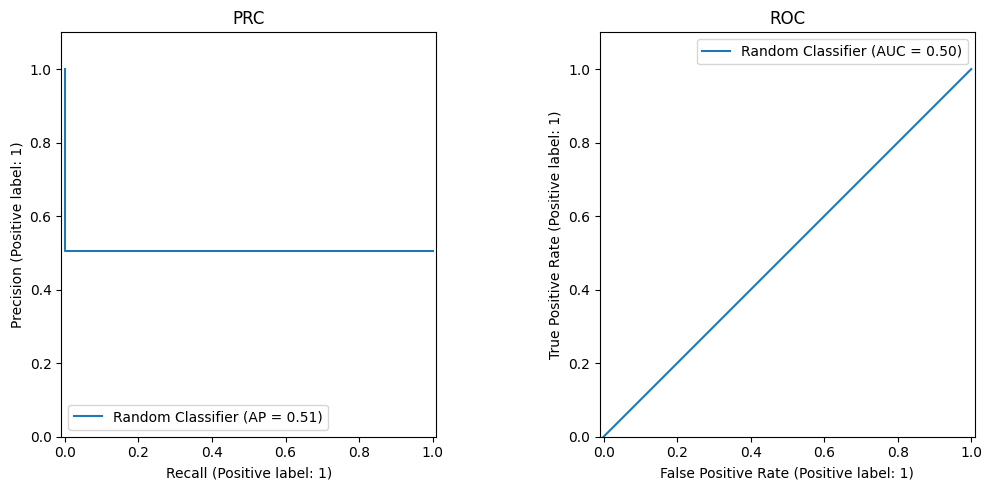

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
svm = LinearSVC(random_state=42, max_iter=10000)
svm_calibrated = CalibratedClassifierCV(svm, cv=5)

param_grid = {'estimator__C': np.logspace(-5, 5, 10)}

scorer = make_scorer(average_precision_score, response_method="predict_proba")

grid_search = GridSearchCV(svm_calibrated, param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
print("Лучший параметр C:", grid_search.best_params_['estimator__C'])
c_svm = grid_search.best_params_['estimator__C']

Лучший параметр C: 0.0001291549665014884


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM with Linear Kernel metrics
AUC-PR: 0.8297
AUC-ROC: 0.8452


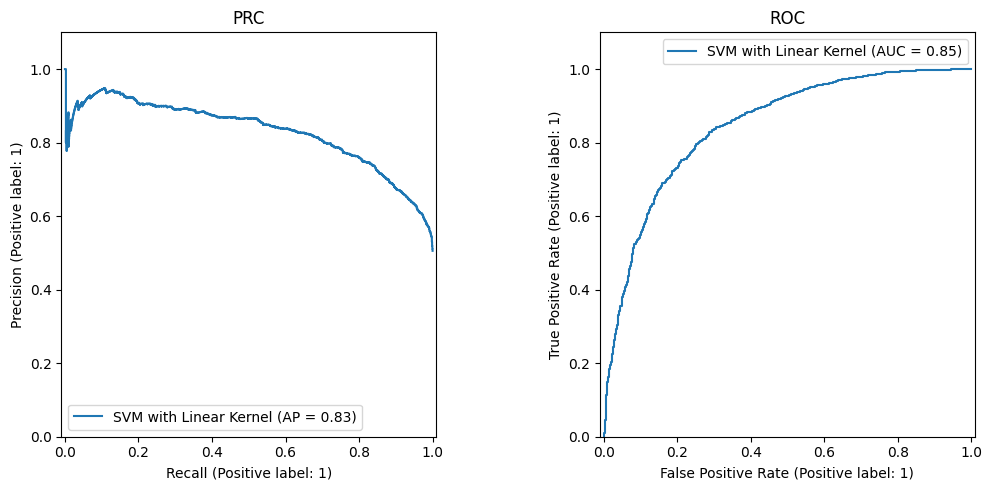

In [ ]:
y_svm_test = best_svm.predict_proba(X_test)[:, 1]
depict_pr_roc(y_test, y_svm_test, 'SVM with Linear Kernel')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Площадь под графикос ROC уже > 0.5, потому что модель лучше чем просто рандомная. PRS также выглядит лучше, что тоже говорит о более разумной модели.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

SVM с линейным ядром значительно превосходит случайный классификатор по всем метрикам, что ожидаемо, так как SVM обучается на данных и находит оптимальную разделяющую гиперплоскость, в отличие от случайного выбора.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.logspace(-5,5,10)}

log_reg = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)
grid_search_lr = GridSearchCV(log_reg, param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

best_lr = grid_search_lr.best_estimator_
print("Лучший параметр C:", grid_search_lr.best_params_['C'])
c_lr = grid_search_lr.best_params_['C']

Лучший параметр C: 0.0016681005372000592


Logistic Regression metrics
AUC-PR: 0.8326
AUC-ROC: 0.8463


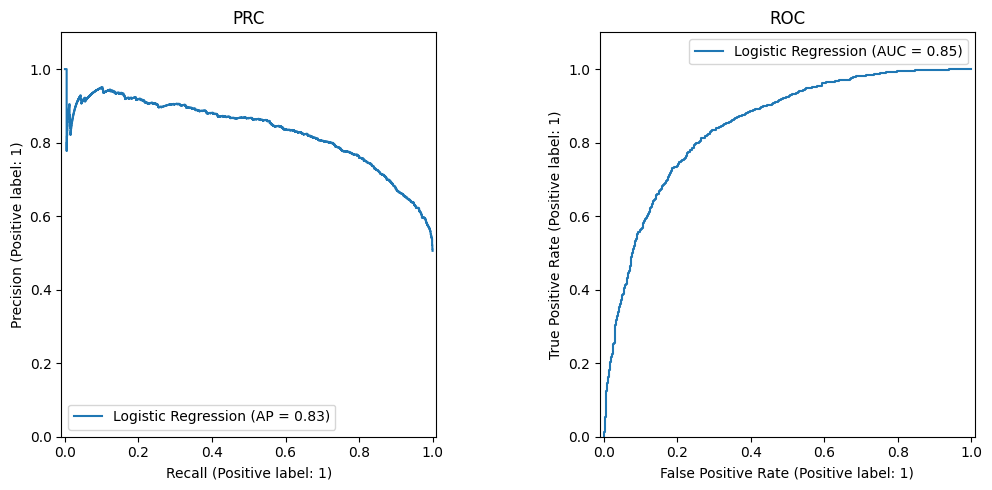

In [ ]:
y_lr_test = best_lr.predict_proba(X_test)[:, 1]
depict_pr_roc(y_test, y_lr_test, 'Logistic Regression')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

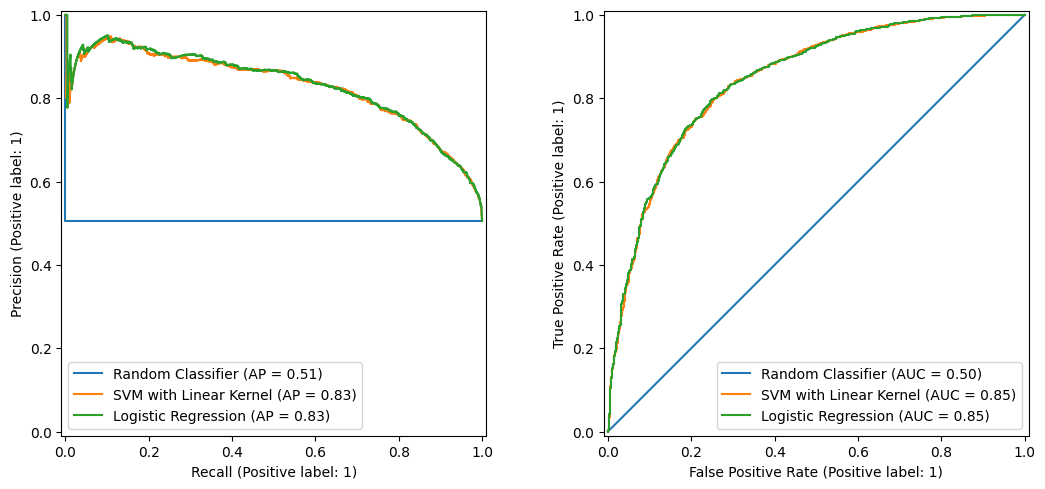

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random Classifier')
RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random Classifier')

PrecisionRecallDisplay.from_predictions(y_test, y_svm_test, ax=ax[0], name='SVM with Linear Kernel')
RocCurveDisplay.from_predictions(y_test, y_svm_test, ax=ax[1], name='SVM with Linear Kernel')

PrecisionRecallDisplay.from_predictions(y_test, y_lr_test, ax=ax[0], name='Logistic Regression')
RocCurveDisplay.from_predictions(y_test, y_lr_test, ax=ax[1], name='Logistic Regression')

plt.tight_layout()
plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:**

Различия между SVM и Logistic Regression минимальны.


#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [ ]:
from sklearn.svm import SVC

RANDOM_STATE = 42

X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    random_state=RANDOM_STATE, n_clusters_per_class=1, class_sep=1.5
)

# y = 2 * y - 1  # преобразуем [0, 1] в [-1, 1] - метки классов для SVM

model = SVC(kernel='linear', C=c_svm, random_state=RANDOM_STATE)
model.fit(X, y)

SVC(C=0.0001291549665014884, kernel='linear', random_state=42)

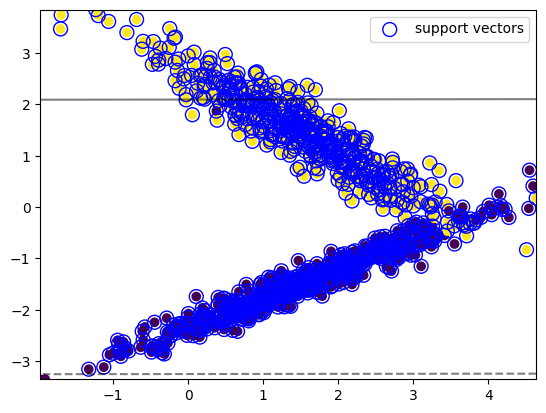

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:,0],
            model.support_vectors_[:,1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорные векторы — это точки, ближайшие к разделяющей гиперплоскости. Они определяют положение и ориентацию разделяющей линии.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
model = LogisticRegression(C = c_lr, random_state=RANDOM_STATE)
model.fit(X, y)

LogisticRegression(C=0.0016681005372000592, random_state=42)

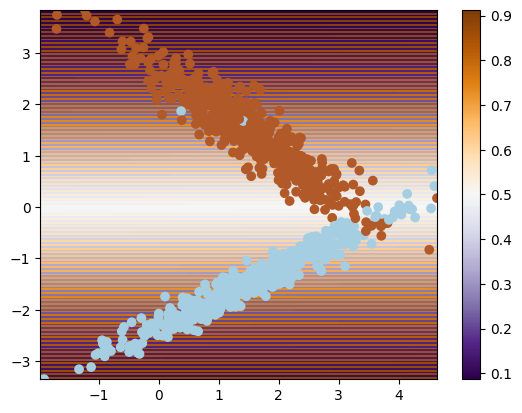

In [ ]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:**

Более насыщенные цвета (красный или синий) указывают на более высокую уверенность модели. А если область белая это демонстроирует неуверенность.


Теоретическое обоснование:

•	В логистической регрессии вероятности классов вычисляются по формуле:

$p(y=+1|x) = \frac{1}{1 + \exp(-z)}, \quad z = w^T x + b$,

где  $w$  — вектор весов,  $b$  — смещение.

•	Когда  $z = 0$ , вероятность положительного класса равна $0.5$. Это соответствует гиперплоскости (в данном случае прямой), которая разделяет пространство признаков на две области:  

$p(y=+1|x) > 0.5$  и  $p(y=+1|x) < 0.5$ .



#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

1.	Ошибка в вычислении bin_middle_points. Вместо (l - r) / 2 должно быть (l + r) / 2, так как мы ищем середину интервала.

2.	Ошибка в вычислении bin_real_ratios. Вместо np.min, необходимо использовать np.mean, чтобы вычислить долю объектов положительного класса в каждом интервале.


In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], color="pink")  #добавили калибровочную кривую идеально откалиброванной модели (диагональ)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

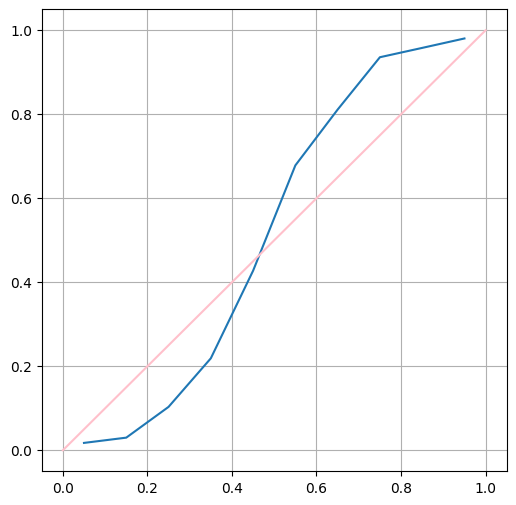

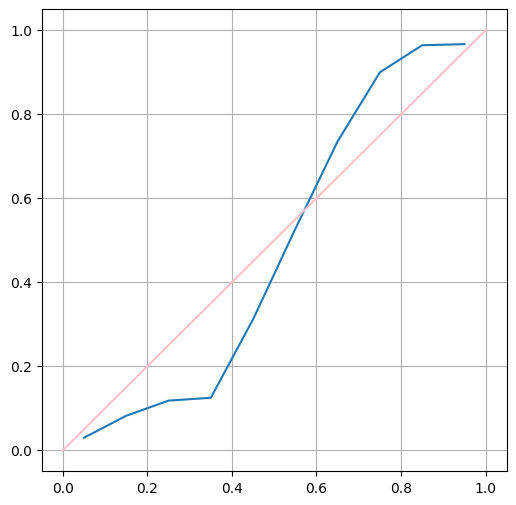

In [ ]:
X, y = make_classification(
    n_samples=10000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(C = c_lr, random_state=RANDOM_STATE)
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict_proba(X_test)[:, 1]

svm = SVC(C = c_svm, random_state=RANDOM_STATE, probability=True)
normalize = lambda x: (x - np.min(x))/(np.max(x) - np.min(x))
svm.fit(X_train, y_train)
svm_preds = svm.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, log_preds)
plot_calibration_curve(y_test, normalize(svm_preds))

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** По графику видно, что для LogisticRegression лучше откалибрована, хотя разница на наших данных не особо заметна.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_log_reg = log_loss(y_test, log_preds)
logloss_svm = log_loss(y_test, svm_preds)

brier_log_reg = brier_score_loss(y_test, log_preds)
brier_svm = brier_score_loss(y_test, svm_preds)

print("LogLoss:")
print(f"Logistic Regression: {logloss_log_reg:.4f}")
print(f"SVM: {logloss_svm:.4f}")

print("\nBrier Score:")
print(f"Logistic Regression: {brier_log_reg:.4f}")
print(f"SVM: {brier_svm:.4f}")

LogLoss:
Logistic Regression: 0.3448
SVM: 0.6852

Brier Score:
Logistic Regression: 0.1009
SVM: 0.2460


Изучите распределение ответов классификаторов при помощи гистограмм

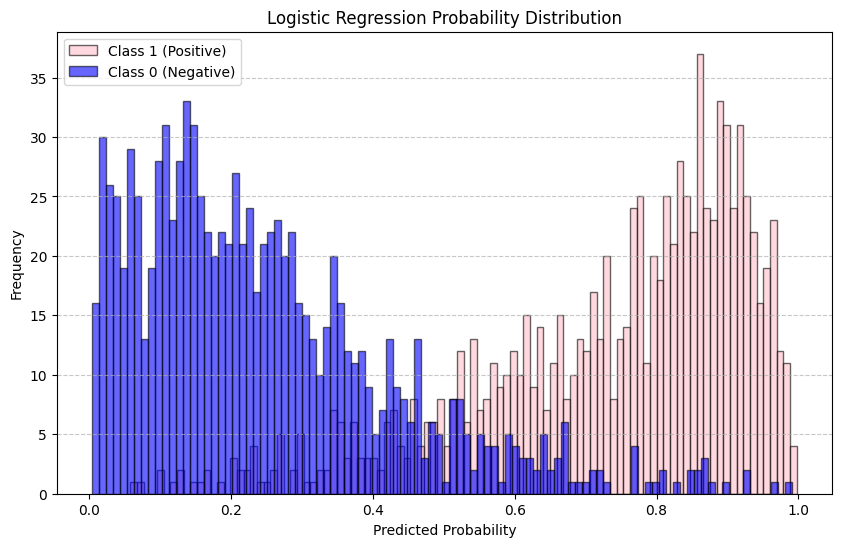

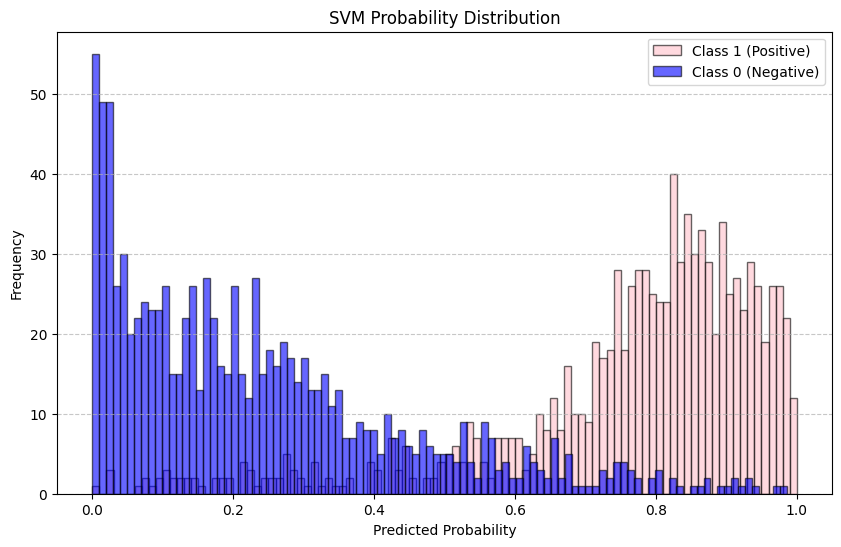

In [ ]:
def plot_probability_histograms(y_test, preds, title):
    """
    Строит гистограммы вероятностей классификатора с разделением по классам.

    Args:
    - y_test: истинные метки классов.
    - preds: предсказанные вероятности.
    - title: заголовок графика.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(
        preds[y_test == 1], bins=100, alpha=0.6, color="pink", label="Class 1 (Positive)", edgecolor="black"
    )
    plt.hist(
        preds[y_test == 0], bins=100, alpha=0.6, color="blue", label="Class 0 (Negative)", edgecolor="black"
    )
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


# Гистограмма для Logistic Regression
plot_probability_histograms(
    y_test, log_preds, "Logistic Regression Probability Distribution"
)

# Гистограмма для SVM
plot_probability_histograms(
    y_test, normalize(svm_preds), "SVM Probability Distribution"
)

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:**

Для логистической регрессии вероятности распределены более равномерно.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

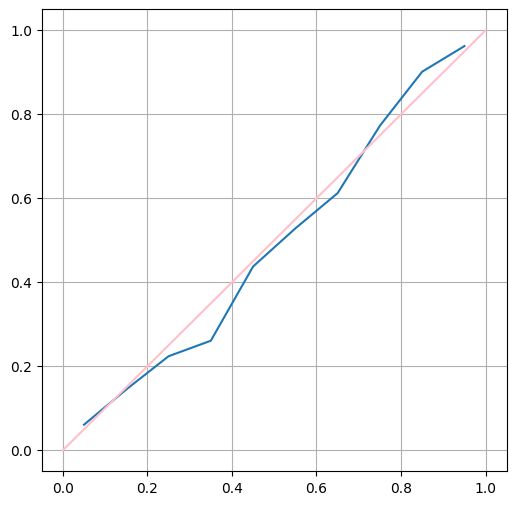

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

svm = SVC(C=c_svm, random_state=RANDOM_STATE)
calibrated_svm = CalibratedClassifierCV(svm, method='sigmoid', cv='prefit')

svm.fit(X_train, y_train)
calibrated_svm.fit(X_train, y_train)

calibrated_svm_preds = calibrated_svm.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, calibrated_svm_preds)

In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_log_reg = log_loss(y_test, log_preds)
logloss_svm = log_loss(y_test, calibrated_svm_preds)

brier_log_reg = brier_score_loss(y_test, log_preds)
brier_svm = brier_score_loss(y_test, calibrated_svm_preds)

print("LogLoss:")
print(f"Logistic Regression: {logloss_log_reg:.4f}")
print(f"SVM: {logloss_svm:.4f}")

print("\nBrier Score:")
print(f"Logistic Regression: {brier_log_reg:.4f}")
print(f"SVM: {brier_svm:.4f}")

LogLoss:
Logistic Regression: 0.3448
SVM: 0.3006

Brier Score:
Logistic Regression: 0.1009
SVM: 0.0862


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, сейчас калибровка очень близка к диагонали (калибровочная кривая идеально откалиброванной модели)

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Platt Scaling: Это логистическая регрессия с одним коэффициентом, которая принимает необработанные оценки модели (например, decision_function у SVM) и преобразует их в вероятности.

 Реализация Platt Scaling для калибровки вероятностей.

  :param raw_scores: Необработанные оценки (например, decision_function)

  :param y_train: Реальные метки классов

  :return: Функция, преобразующая оценки в вероятности

1. Преобразуем метки в {0, 1}
2. Обучаем логистическую регрессию
3. Возвращаем функцию для преобразования оценок в вероятности
4. Получаем необработанные оценки SVM
5. Калибровка
6. Применяем к тестовым оценкам
7. Визуализация


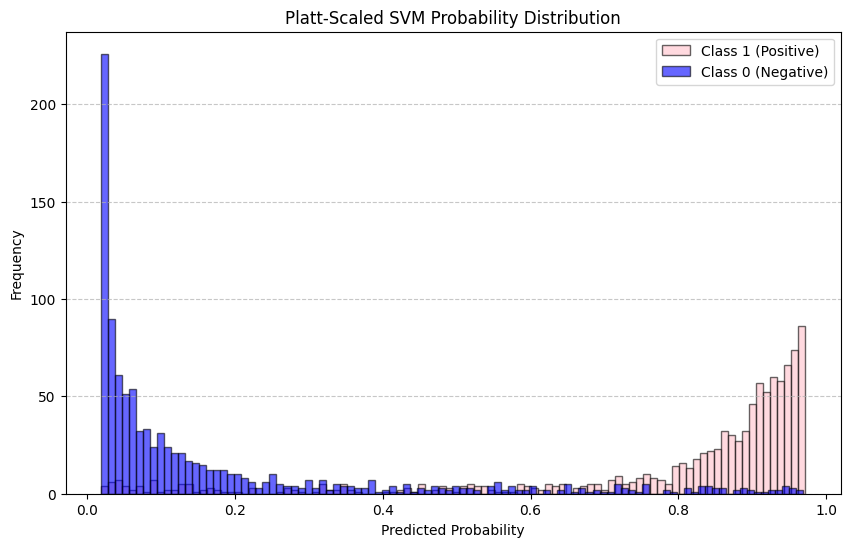

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def platt_scaling(raw_scores, y_train):
    y_train_bin = (y_train == 1).astype(int)

    platt_model = LogisticRegression()
    platt_model.fit(raw_scores.reshape(-1, 1), y_train_bin)

    def calibrated_probabilities(scores):
        return platt_model.predict_proba(scores.reshape(-1, 1))[:, 1]

    return calibrated_probabilities

raw_scores_train = svm.decision_function(X_train)
raw_scores_test = svm.decision_function(X_test)

calibrator = platt_scaling(raw_scores_train, y_train)

calibrated_probs_test = calibrator(raw_scores_test)

plot_probability_histograms(
    y_test, calibrated_probs_test, "Platt-Scaled SVM Probability Distribution"
)

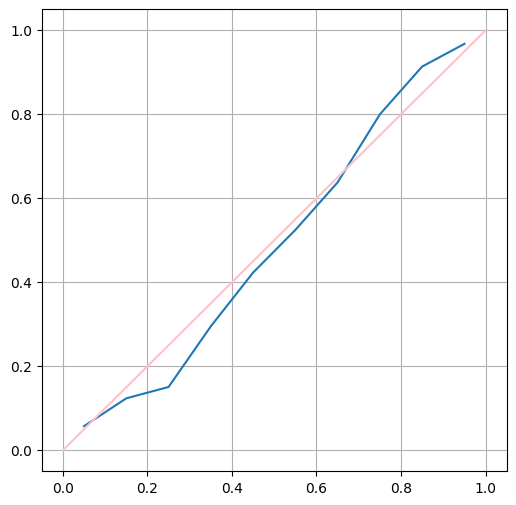

In [ ]:
plot_calibration_curve(y_test, calibrated_probs_test)

In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

log_loss_platt = log_loss(y_test, calibrated_probs_test)
brier_score_platt = brier_score_loss(y_test, calibrated_probs_test)

print(f"LogLoss (Platt Scaled): {log_loss_platt:.4f}")
print(f"Brier Score (Platt Scaled): {brier_score_platt:.4f}")

LogLoss (Platt Scaled): 0.3015
Brier Score (Platt Scaled): 0.0868


При этом ранее мы получлили такие результаты:

- LogLoss:

Logistic Regression: 0.3448

Calibrated SVM: 0.3006

- Brier Score:

Logistic Regression: 0.1009

Сalibrated SVM: 0.0862

Можно сделать вывод, что результаты сравнимы с Сalibrated SVM.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

100%|██████████| 22.2k/22.2k [00:00<00:00, 12.8MB/s]

Extracting files...


In [ ]:
# Прочитаем датасет
data = pd.read_csv(path)

# Заменим пропуски категориальных переменных
categorical_cols = ["Marital Status", "Gender", "Education", "Occupation", "Home Owner", "Commute Distance", "Region"]
data[categorical_cols] = data[categorical_cols].fillna("undefined")

# Отделим X и y
y = data["Purchased Bike"].map({"Yes": 1, "No": 0})
X = data.drop("Purchased Bike", axis=1)

# Разделим на категориальные признаки и числовые
numerical_cols = ["Income", "Children", "Cars", "Age"]
X_numerical = X[numerical_cols]
X_categorical = X[categorical_cols]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

LogisticRegression and OrdinalEncoder metrics
AUC-PR: 0.6179
AUC-ROC: 0.6359
Время обучения модели: 0.0429 секунд


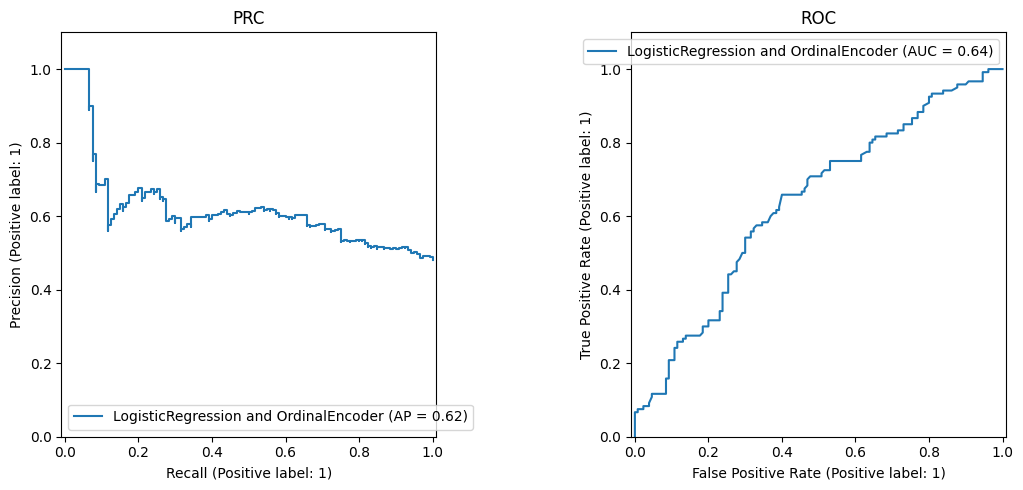

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import time

ordinal_encoder = OrdinalEncoder()
X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

start_time = time.time()
log_reg = LogisticRegression(random_state=777, C = c_lr)
log_reg.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba, "LogisticRegression and OrdinalEncoder")
print(f"Время обучения модели: {training_time:.4f} секунд")

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

LogisticRegression and One-Hot Encoding metrics
AUC-PR: 0.6032
AUC-ROC: 0.6139
Время кодирования: 0.0281 секунд
Время обучения модели: 0.0167 секунд


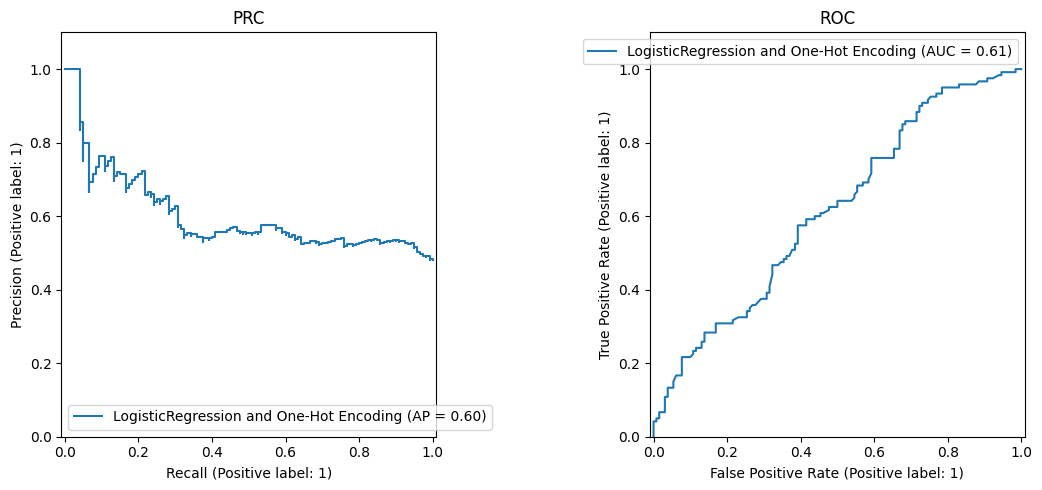

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)  # Заменяем sparse на sparse_output
column_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, X_categorical.columns)], remainder="passthrough"
)

start_encoding_time = time.time()
X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)
encoding_time = time.time() - start_encoding_time

start_time = time.time()
log_reg = LogisticRegression(random_state=777, C = c_lr)
log_reg.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba, "LogisticRegression and One-Hot Encoding")

print(f"Время кодирования: {encoding_time:.4f} секунд")
print(f"Время обучения модели: {training_time:.4f} секунд")

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

LogisticRegression and Mean-Target Encoding metrics
AUC-PR: 0.6545
AUC-ROC: 0.6571
Время кодирования: 0.0434 секунд
Время обучения модели: 0.0081 секунд


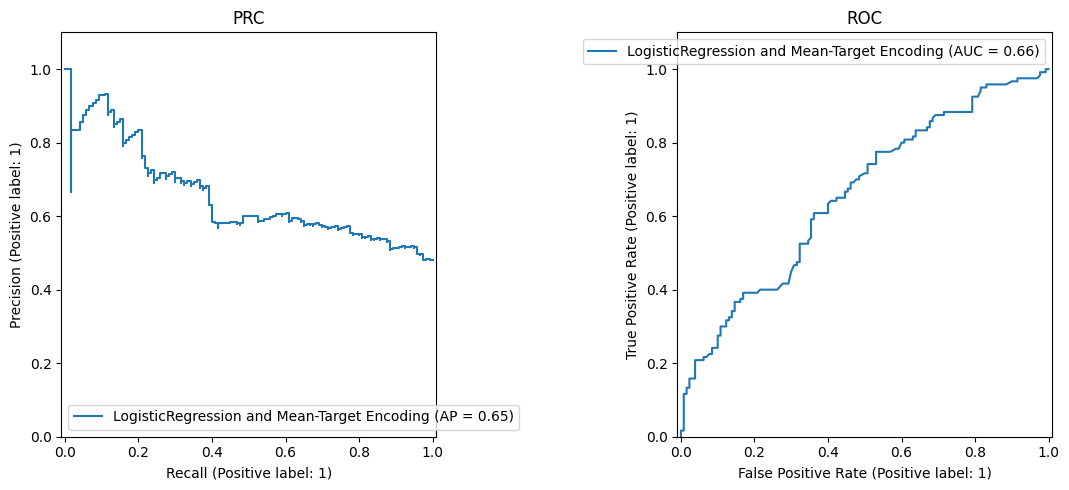

In [ ]:
class MeanTargetEncoder:
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.global_mean = None
        self.feature_means = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        for col in self.categorical_features:
            self.feature_means[col] = y.groupby(X[col]).mean()

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_features:
            X_encoded[col] = X[col].map(self.feature_means[col]).fillna(self.global_mean)
        return X_encoded

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

encoder = MeanTargetEncoder(categorical_features=X_categorical.columns)
start_encoding_time = time.time()
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)
encoding_time = time.time() - start_encoding_time

start_time = time.time()
log_reg = LogisticRegression(random_state=777, C = c_lr)
log_reg.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba, "LogisticRegression and Mean-Target Encoding")
print(f"Время кодирования: {encoding_time:.4f} секунд")
print(f"Время обучения модели: {training_time:.4f} секунд")

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

LogisticRegression and Efficient Mean Target Encoder metrics
AUC-PR: 0.6545
AUC-ROC: 0.6571


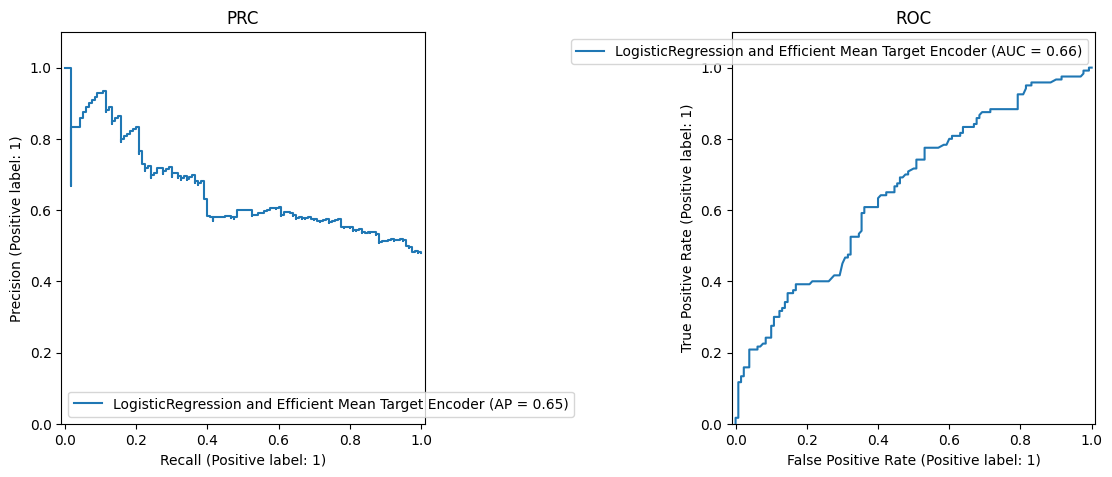

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EfficientMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.global_mean = None
        self.feature_means = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        for col in self.categorical_features:
            self.feature_means[col] = y.groupby(X[col]).mean()
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_features:
            X_encoded[col] = X[col].map(self.feature_means[col]).fillna(self.global_mean)
        return X_encoded

efficient_encoder = EfficientMeanTargetEncoder(categorical_features=X_categorical.columns)
X_train_encoded = efficient_encoder.fit_transform(X_train, y_train)
X_test_encoded = efficient_encoder.transform(X_test)

log_reg = LogisticRegression(random_state=777, C = c_lr)
log_reg.fit(X_train_encoded, y_train)

y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba, 'LogisticRegression and Efficient Mean Target Encoder')

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

LogisticRegression with Noisy Mean Target Encoder metrics
AUC-PR: 0.6518
AUC-ROC: 0.6611


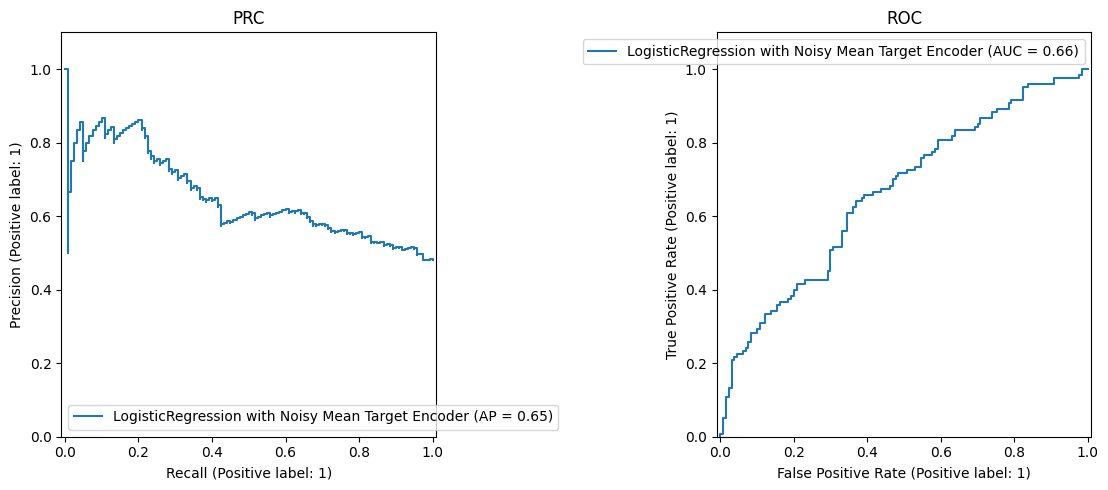

In [ ]:
class NoisyMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise_level=0.01, random_state=42):
        self.categorical_features = categorical_features
        self.noise_level = noise_level
        self.global_mean = None
        self.feature_means = {}
        self.random_state = random_state

    def fit(self, X, y):
        self.global_mean = y.mean()
        for col in self.categorical_features:
            self.feature_means[col] = y.groupby(X[col]).mean()
        return self

    def transform(self, X):
        rng = np.random.default_rng(self.random_state)
        X_encoded = X.copy()
        for col in self.categorical_features:
            # Map mean target values and add noise
            means = X[col].map(self.feature_means[col]).fillna(self.global_mean)
            noise = rng.normal(loc=0.0, scale=self.noise_level, size=len(X))
            X_encoded[col] = means + noise
        return X_encoded

noise_level = 0.01

noisy_encoder = NoisyMeanTargetEncoder(categorical_features=X_categorical.columns, noise_level=noise_level)
X_train_noisy_encoded = noisy_encoder.fit_transform(X_train, y_train)
X_test_noisy_encoded = noisy_encoder.transform(X_test)

log_reg_noisy = LogisticRegression(random_state=777, C=c_lr)
log_reg_noisy.fit(X_train_noisy_encoded, y_train)

y_pred_proba_noisy = log_reg_noisy.predict_proba(X_test_noisy_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba_noisy, 'LogisticRegression with Noisy Mean Target Encoder')

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Удалось добиться увеличение метрики AUC-ROC, что говорит о том, что модель лучше различает классы в целом. При этом AUC-PR не улучшился.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




LogisticRegression with Fold-Based Mean Target Encoder metrics
AUC-PR: 0.4889
AUC-ROC: 0.5000


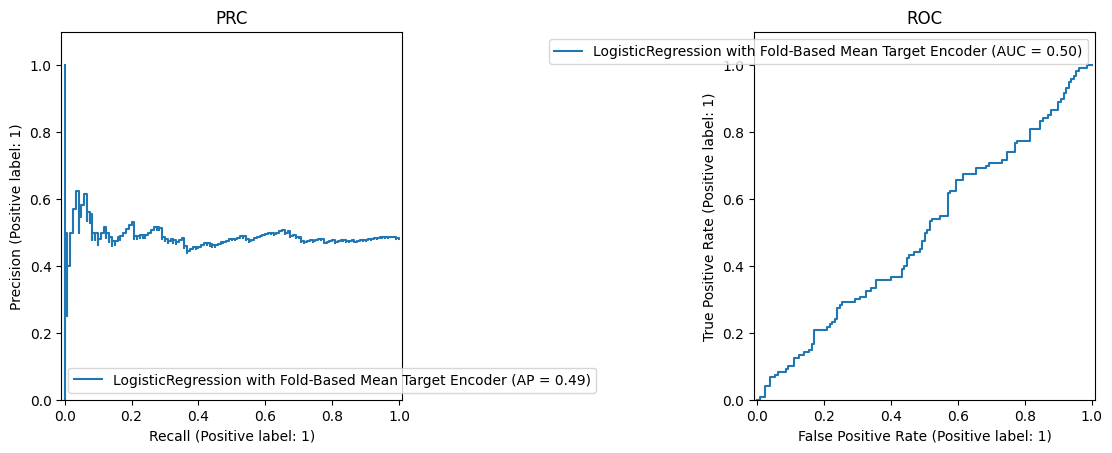

In [ ]:
from sklearn.model_selection import KFold

class FoldMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise_level=0.01, n_splits=5, random_state=42):
        self.categorical_features = categorical_features
        self.noise_level = noise_level
        self.n_splits = n_splits
        self.global_mean = None
        self.feature_means = {}
        self.random_state = random_state

    def fit(self, X, y):
        self.global_mean = y.mean()
        return self

    def transform(self, X, y=None):
        rng = np.random.default_rng(self.random_state)
        X_encoded = X.copy()
        if y is None:
            for col in self.categorical_features:
                means = X[col].map(self.feature_means.get(col, {})).fillna(self.global_mean)
                noise = rng.normal(loc=0.0, scale=self.noise_level, size=len(X))
                X_encoded[col] = means + noise
            return X_encoded

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        fold_means = {col: {} for col in self.categorical_features}

        X["target"] = y
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            for col in self.categorical_features:
                col_means = X_train.groupby(col)["target"].mean()
                fold_means[col].update(col_means.to_dict())

        X = X.drop("target", axis=1)
        self.feature_means = fold_means

        for col in self.categorical_features:
            means = X[col].map(fold_means[col]).fillna(self.global_mean)
            noise = rng.normal(loc=0.0, scale=self.noise_level, size=len(X))
            X_encoded[col] = means + noise

        return X_encoded

fold_encoder = FoldMeanTargetEncoder(
    categorical_features=X_categorical.columns, noise_level=0.01, n_splits=5, random_state=42
)

X_train_fold_encoded = fold_encoder.fit_transform(X_train, y_train)
X_test_fold_encoded = fold_encoder.transform(X_test)

log_reg_fold = LogisticRegression(random_state=777, C=c_lr)
log_reg_fold.fit(X_train_fold_encoded, y_train)

y_pred_proba_fold = log_reg_fold.predict_proba(X_test_fold_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba_fold, 'LogisticRegression with Fold-Based Mean Target Encoder')

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_auc_pr(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

LogisticRegression and Smooth Mean Target Encoding (C=10) metrics
AUC-PR: 0.6709
AUC-ROC: 0.6598
Лучшее значение параметра сглаживания C: 10, AUC-PR: 0.6688


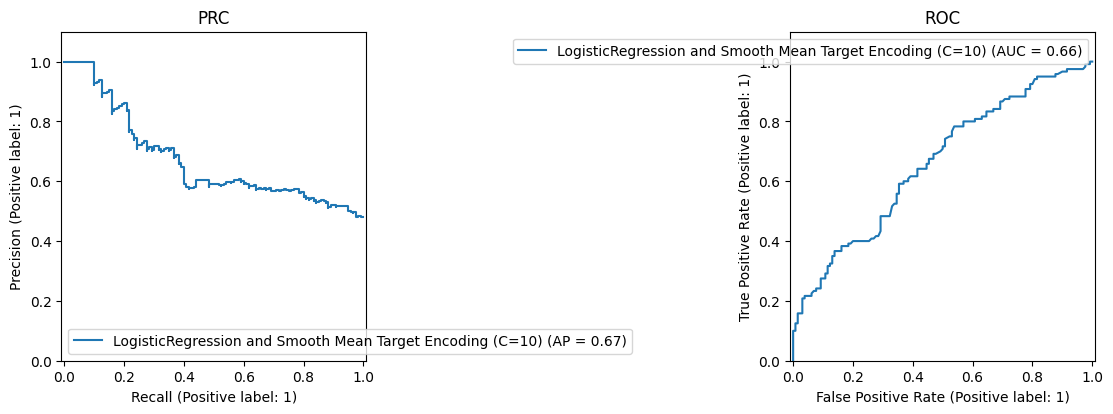

In [ ]:
class SmoothMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, smoothing_param=10, add_noise=False, random_state=42):
        self.categorical_features = categorical_features
        self.smoothing_param = smoothing_param
        self.add_noise = add_noise
        self.global_mean = None
        self.feature_stats = {}
        self.random_state = random_state

    def fit(self, X, y):
        self.global_mean = y.mean()
        for col in self.categorical_features:
            col_stats = X[col].to_frame().join(y).groupby(col).agg(['mean', 'count'])[y.name]
            # Сглаживание
            col_stats['smoothed_mean'] = (
                (col_stats['count'] * col_stats['mean'] + self.smoothing_param * self.global_mean)
                / (col_stats['count'] + self.smoothing_param)
            )
            self.feature_stats[col] = col_stats['smoothed_mean'].to_dict()
        return self

    def transform(self, X):
        rng = np.random.default_rng(self.random_state)
        X_encoded = X.copy()
        for col in self.categorical_features:
            means = X[col].map(self.feature_stats[col]).fillna(self.global_mean)
            if self.add_noise:
                noise = rng.normal(0, 0.01, size=len(X))
                X_encoded[col] = means + noise
            else:
                X_encoded[col] = means
        return X_encoded

smoothing_param = 10
encoder = SmoothMeanTargetEncoder(categorical_features=X_categorical.columns, smoothing_param=smoothing_param)

X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

log_reg = LogisticRegression(random_state=777, C=c_lr)
log_reg.fit(X_train_encoded, y_train)

y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

depict_pr_roc(y_test, y_pred_proba, f'LogisticRegression and Smooth Mean Target Encoding (C={smoothing_param})')

best_c = None
best_auc_pr = -np.inf

for c in [1, 5, 10, 20, 50, 100]:
    encoder = SmoothMeanTargetEncoder(categorical_features=X_categorical.columns, smoothing_param=c)
    X_train_encoded = encoder.fit_transform(X_train, y_train)
    X_test_encoded = encoder.transform(X_test)

    log_reg = LogisticRegression(random_state=777, C=c_lr)
    log_reg.fit(X_train_encoded, y_train)

    y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]
    auc_pr = calculate_auc_pr(y_test, y_pred_proba)

    if auc_pr > best_auc_pr:
        best_auc_pr = auc_pr
        best_c = c

print(f'Лучшее значение параметра сглаживания C: {best_c}, AUC-PR: {best_auc_pr:.4f}')

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [ ]:
for col in X_numerical.columns:
    X_numerical.loc[:, col] = X_numerical[col].fillna(X_numerical[col].mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [ ]:
print("Количество уникальных значений у числовых признаков:")
X_numerical.nunique()

Количество уникальных значений у числовых признаков:


,0
Income,17
Children,7
Cars,6
Age,54


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

LogisticRegression and numerical features metrics
AUC-PR: 0.5611
AUC-ROC: 0.6282


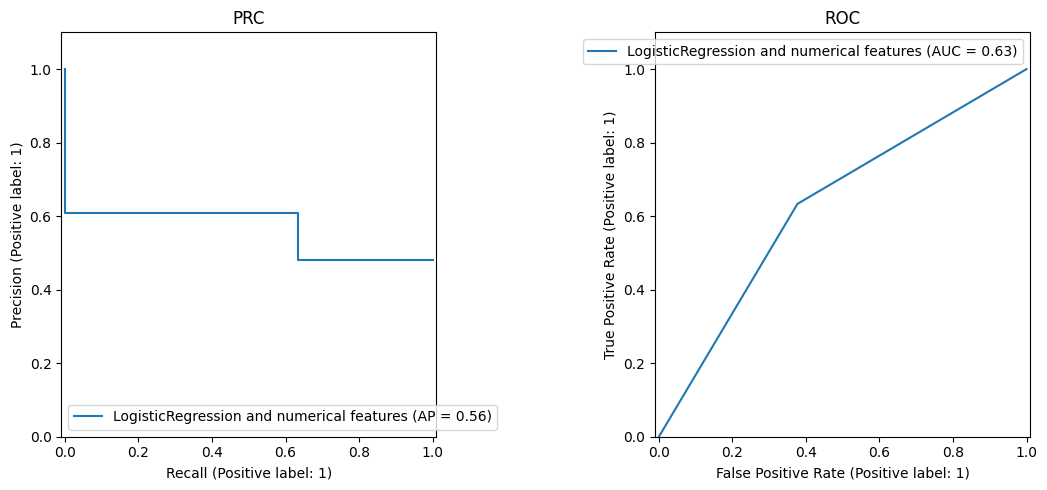

In [ ]:
model = LogisticRegression(random_state=777, C=c_lr, max_iter=500)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
depict_pr_roc(y_test, predicted, "LogisticRegression and numerical features")



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

- One-Hot-Encoding:

Подходит для признаков с малым числом уникальных значений. Взрывается размерность, если много уникальных значений.

- Счетчики (Target Encoding):

Снижает размерность. Учитывает зависимость признака от целевой переменной.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 19:47:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.5’

adult.data.5            [  <=>               ]   3.79M  15.8MB/s    in 0.2s    

2024-12-02 19:47:57 (15.8 MB/s) - ‘adult.data.5’ saved [3974305]



In [ ]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4687,45,Private,123283,HS-grad,9,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,15,United-States,0


In [ ]:
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical_columns = [
    'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [ ]:
train_data, test_data = train_test_split(
    df, test_size=0.25, random_state=777, stratify=df['income']
)

X_train = train_data.drop("income", axis=1)
y_train = train_data["income"]
X_test = test_data.drop("income", axis=1)
y_test = test_data["income"]

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

print(f"Количество новых признаков после One-Hot Encoding: {X_train_encoded.shape[1]}")

Количество новых признаков после One-Hot Encoding: 102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

model = LogisticRegression()

model.fit(X_train_encoded, y_train)
predicted = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, predicted)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.6854


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [ ]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=777, stratify=y_train
)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
features_40 = np.argsort(np.abs(model.coef_[0]))[::-1][:40]
model.fit(X_train_sub[:, features_40], y_train_sub )
predicted = model.predict_proba(X_val[:, features_40])[:, 1]

auc_pr = average_precision_score(y_val, predicted)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.6609


Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

X_train_sub <- X_train_encoded

y_train_sub <- y_train

X_val <- X_test

y_val <- y_test

In [ ]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=777, stratify=y_train
)

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scale', StandardScaler(), numerical_features)
])

X_train_encoded = column_transformer.fit_transform(X_train_sub)
X_val_encoded = column_transformer.transform(X_val)

model = LogisticRegression()

model.fit(X_train_encoded, y_train_sub)
predicted = model.predict_proba(X_val_encoded)[:, 1]

auc_pr = average_precision_score(y_val, predicted)
print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.7734


In [ ]:
features_40 = np.argsort(list(map(abs,model.coef_[0])))[::-1][:40]
model.fit(X_train_encoded[:, features_40], y_train_sub)
predicted = model.predict_proba(X_val_encoded[:, features_40])[:, 1]

auc_pr = average_precision_score(y_val, predicted)

print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.7415


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

print(f"AUC-PR без масштабирования: {auc_pr:.4f}")
print("Список главных признаков без масштабирования:")
print(features_40)

column_transformer = ColumnTransformer([
    ('ohe_scale', Pipeline([
        ('ohe', OneHotEncoder(handle_unknown="ignore")),
        ('scaler', StandardScaler(with_mean=False))
    ]), categorical_columns),
    ('scale', StandardScaler(), numerical_columns)
])

X_train_encoded = column_transformer.fit_transform(X_train_sub)
X_val_encoded = column_transformer.transform(X_val)

model = LogisticRegression()
model.fit(X_train_encoded, y_train_sub)
predicted = model.predict_proba(X_val_encoded)[:, 1]

auc_pr = average_precision_score(y_val, predicted)
print(f"AUC-PR после масштабирования: {auc_pr:.4f}")

features_40 = np.argsort(np.abs(model.coef_[0]))[::-1][:40]
model.fit(X_train_encoded[:, features_40], y_train_sub)
predicted = model.predict_proba(X_val_encoded[:, features_40])[:, 1]

auc_pr = average_precision_score(y_val, predicted)
print(f"AUC-PR для 40 главных признаков после масштабирования: {auc_pr:.4f}")

print("Список главных признаков после масштабирования:")
print(features_40)

AUC-PR без масштабирования: 0.7415
Список главных признаков без масштабирования:
[105   1  45   2  64   4  41  12  14  62   7   5  40  44  82  66   3  96
  11  84  71  61  93 102  49  47  65   0  28  90  59  52   6  22  31  46
  85  70  95  77]
AUC-PR после масштабирования: 0.7725
AUC-PR для 40 главных признаков после масштабирования: 0.7667
Список главных признаков после масштабирования:
[105  27  29  22 104 107  41  50  58 102  40  25 106  37  47  30  36  55
  52  86   6  20  57  99  48  38  10  31  64  49   8  88  28  19  32   0
  60  21   9  14]


Качество на всех признаках улучшилось, так как логистическая регрессия лучше работает на отмасштабированных данных.

При нормализации вес признака перестанет зависеть от его масштаба, что может привести к другим результатам отбора.

Список главных признаков также изменился.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:**

Признаки с высокой корреляцией: Если признак имеет высокую корреляцию с целевой переменной, это обычно означает, что он несет много информации о том, как изменяется целевая переменная. Например, в задачах регрессии, такие признаки могут иметь высокую связь с предсказаниями целевой переменной. В задачах классификации, такие признаки могут лучше разделять классы, так как они содержат явную связь с целевой переменной.

Признаки с низкой корреляцией: Признаки, которые имеют низкую корреляцию с целевой переменной, могут быть менее полезными для построения модели, так как они не содержат существенной информации для предсказания целевой переменной.
Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

start_time = time.time()

numerical_correlations = X_train[numerical_columns].corrwith(y_train)

categorical_correlations = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_col = le.fit_transform(X_train[col])
    categorical_correlations[col] = cramers_v(encoded_col, y_train)

all_correlations = pd.concat([
    numerical_correlations,
    pd.Series(categorical_correlations, name='correlation')
])

top_40_features = all_correlations.abs().sort_values(ascending=False).head(40).index

X_train_filtered = X_train[top_40_features]
X_test_filtered = X_test[top_40_features]

categorical_features = [col for col in X_train_filtered.columns if col in categorical_columns]
numerical_features = [col for col in X_train_filtered.columns if col in numerical_columns]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scale', StandardScaler(), numerical_features)
])

X_train_encoded = column_transformer.fit_transform(X_train_filtered)
X_test_encoded = column_transformer.transform(X_test_filtered)

end_time = time.time()
print(f"Время отбора признаков: {end_time - start_time:.2f} секунд")

model = LogisticRegression(max_iter=5000, solver='lbfgs')
model.fit(X_train_encoded, y_train)
predicted = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, predicted)

print(f"AUC-PR: {auc_pr:.4f}")

Время отбора признаков: 0.34 секунд
AUC-PR: 0.7672


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind

def t_statistic(X, y):
    t_values = []
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])

        class_1 = X[y == 1][col]
        class_0 = X[y == 0][col]

        t_stat, _ = ttest_ind(class_1, class_0, equal_var=False)
        t_values.append(t_stat)
    return pd.Series(t_values, index=X.columns)

start_time = time.time()

t_stats = t_statistic(X_train, y_train)

top_40_features = t_stats.abs().sort_values(ascending=False).head(40).index

X_train_filtered = X_train[top_40_features]
X_test_filtered = X_test[top_40_features]

categorical_features = [col for col in X_train_filtered.columns if col in categorical_columns]
numerical_features = [col for col in X_train_filtered.columns if col in numerical_columns]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scale', StandardScaler(), numerical_features)
])

X_train_encoded = column_transformer.fit_transform(X_train_filtered)
X_test_encoded = column_transformer.transform(X_test_filtered)

end_time = time.time()
print(f"Время отбора признаков: {end_time - start_time:.2f} секунд")

model = LogisticRegression(max_iter=5000, solver='lbfgs')
model.fit(X_train_encoded, y_train)

predicted = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, predicted)

print(f"AUC-PR: {auc_pr:.4f}")

Время отбора признаков: 0.22 секунд
AUC-PR: 0.6518


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [ ]:
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical_columns = [
    'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [ ]:
def feature_importance(X_train, y_train):
    model = LogisticRegression(max_iter=5000, solver='lbfgs')
    model.fit(X_train, y_train)
    return model.coef_[0]

def recursive_feature_elimination(X_train, y_train, k, m):
    features = X_train.columns.tolist()
    step = m
    current_features = features

    while len(current_features) > k:
        importances = feature_importance(X_train[current_features], y_train)

        importance_sorted = sorted(zip(importances, current_features), key=lambda x: abs(x[0]))

        least_important = [x[1] for x in importance_sorted[:step]]

        current_features = [f for f in current_features if f not in least_important]

        X_train_filtered = X_train[current_features]
        model = LogisticRegression(max_iter=5000, solver='lbfgs')
        model.fit(X_train_filtered, y_train)
        predicted = model.predict_proba(X_train_filtered)[:, 1]

        auc_roc = roc_auc_score(y_train, predicted)
        print(f"Количество признаков: {len(current_features)}, AUC-ROC: {auc_roc:.4f}")

    return current_features

start_time = time.time()

column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('scale', StandardScaler(), numerical_columns)
    ])

top_40_features = recursive_feature_elimination(X_train, y_train, k=40, m=5)

X_train_filtered = X_train[top_40_features]
X_test_filtered = X_test[top_40_features]

X_train_encoded = column_transformer.fit_transform(X_train_filtered)
X_test_encoded = column_transformer.transform(X_test_filtered)

model = LogisticRegression(max_iter=5000, solver='lbfgs')
model.fit(X_train_encoded, y_train)
predicted = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, predicted)

end_time = time.time()
print(f"Время отбора признаков: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")

Время отбора признаков: 0.42 секунд
AUC-PR: 0.6518


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Метод с обычной корреляцией показал у меня наилучший результат.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 20:06:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [ <=>                ] 434.15K  --.-KB/s    in 0.1s    

2024-12-02 20:06:42 (3.15 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]

numeric_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(), categorical_features)
            ])

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])

        model.fit(X_train, y_train)

        y_pred_prob = model.predict_proba(X_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_pred_prob)
        auc_pr = average_precision_score(y_test, y_pred_prob)

        profit = (y_pred_prob > 0.5).sum() * 8  # прибыль за звонки, где вероятность > 0.5
        revenue = (y_pred_prob > 0.5).sum() * 10  # выручка за звонки, где вероятность > 0.5
        cost = (y_pred_prob > 0.5).sum() * 2  # расходы на звонки, где вероятность > 0.5

        metrics.append({
            "AUC-ROC": auc_roc,
            "AUC-PR": auc_pr,
            "Profit": profit,
            "Revenue": revenue,
            "Cost": cost
        })

    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [ ]:
results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)
print(results)

print(f"Средний AUC-ROC: {results['AUC-ROC'].mean():.4f}")

    AUC-ROC
0  0.780228
1  0.801102
2  0.781426
3  0.804808
4  0.791599
Средний AUC-ROC: 0.7918


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)
print(results)

print(f"Средний AUC-ROC: {results['AUC-ROC'].mean():.4f}")

print(f"Средний AUC-PR: {results['AUC-PR'].mean():.4f}")

print(f"Средняя выручка: {results['Revenue'].mean():.2f} долларов")

print(f"Стандартное отклонение выручки: {results['Revenue'].std():.2f} долларов")

print(f"Средний профит: {results['Profit'].mean():.2f} долларов")

print(f"Стандартное отклонение профита: {results['Profit'].std():.2f} долларов")

print(f"Средняя стоимость звонков: {results['Cost'].mean():.2f} долларов")

    AUC-ROC    AUC-PR  Profit  Revenue  Cost
0  0.780228  0.430556    2456     3070   614
1  0.801102  0.472721    2560     3200   640
2  0.781426  0.449833    2912     3640   728
3  0.804808  0.454738    2448     3060   612
4  0.791599  0.455881    2424     3030   606
Средний AUC-ROC: 0.7918
Средний AUC-PR: 0.4527
Средняя выручка: 3200.00 долларов
Стандартное отклонение выручки: 254.46 долларов
Средний профит: 2560.00 долларов
Стандартное отклонение профита: 203.57 долларов
Средняя стоимость звонков: 640.00 долларов


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(), categorical_features)
            ])

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])

        model.fit(X_train, y_train)

        y_pred_prob = model.predict_proba(X_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_pred_prob)
        auc_pr = average_precision_score(y_test, y_pred_prob)

        profit = (y_pred_prob > 0.5).sum() * 8
        cost = (y_pred_prob > 0.5).sum() * 2
        revenue = np.random.uniform(0, 20, size=(y_pred_prob > 0.5).sum()).sum()


        metrics.append({
            "AUC-ROC": auc_roc,
            "AUC-PR": auc_pr,
            "Profit": profit,
            "Revenue": revenue,
            "Cost": cost
        })

    return pd.DataFrame(metrics)

In [ ]:
results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)
print(results)

print(f"Средний AUC-ROC: {results['AUC-ROC'].mean():.4f}")

print(f"Средний AUC-PR: {results['AUC-PR'].mean():.4f}")

print(f"Средняя выручка: {results['Revenue'].mean():.2f} долларов")

print(f"Стандартное отклонение выручки: {results['Revenue'].std():.2f} долларов")

print(f"Средний профит: {results['Profit'].mean():.2f} долларов")

print(f"Стандартное отклонение профита: {results['Profit'].std():.2f} долларов")

print(f"Средняя стоимость звонков: {results['Cost'].mean():.2f} долларов")

    AUC-ROC    AUC-PR  Profit      Revenue  Cost
0  0.780228  0.430556    2456  3059.639005   614
1  0.801102  0.472721    2560  3185.398831   640
2  0.781426  0.449833    2912  3738.752522   728
3  0.804808  0.454738    2448  3244.966524   612
4  0.791599  0.455881    2424  3094.854207   606
Средний AUC-ROC: 0.7918
Средний AUC-PR: 0.4527
Средняя выручка: 3264.72 долларов
Стандартное отклонение выручки: 274.91 долларов
Средний профит: 2560.00 долларов
Стандартное отклонение профита: 203.57 долларов
Средняя стоимость звонков: 640.00 долларов


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

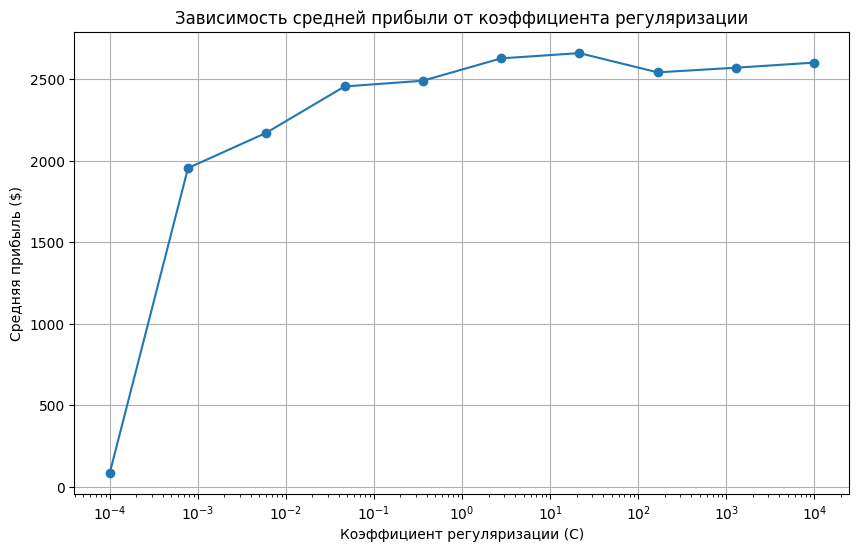

Максимальная прибыль достигается при C = 21.5443 с прибылью 2659.03 долларов.


In [ ]:
def cross_validate_profit_with_regularization(
    X,
    y,
    n_splits=5,
    random_state=42,
    shuffle=True,
    regularization_values=np.logspace(-4, 4, 10)
):
    profits = []

    for C in regularization_values:
        metrics = []
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), numeric_features),
                    ('cat', OneHotEncoder(), categorical_features)
                ])

            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(C=C, max_iter=1000))
            ])

            model.fit(X_train, y_train)

            y_pred_prob = model.predict_proba(X_test)[:, 1]

            auc_roc = roc_auc_score(y_test, y_pred_prob)
            pr_auc = average_precision_score(y_test, y_pred_prob)

            revenue = np.random.uniform(0, 20, size=(y_pred_prob > 0.5).sum()).sum()
            cost = (y_pred_prob > 0.5).sum() * 2
            profit = revenue - cost

            metrics.append({
                "AUC-ROC": auc_roc,
                "AUC-PR": pr_auc,
                "Profit": profit,
                "Revenue": revenue,
                "Cost": cost
            })

        mean_profit = np.mean([m['Profit'] for m in metrics])
        profits.append(mean_profit)

    return profits, regularization_values

profits, regularization_values = cross_validate_profit_with_regularization(X, y, n_splits=5, random_state=42, shuffle=True)

plt.figure(figsize=(10, 6))
plt.plot(regularization_values, profits, marker='o')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Средняя прибыль ($)')
plt.title('Зависимость средней прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

best_C_index = np.argmax(profits)
best_C = regularization_values[best_C_index]
best_profit = profits[best_C_index]

print(f"Максимальная прибыль достигается при C = {best_C:.4f} с прибылью {best_profit:.2f} долларов.")

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Нет, значения получались абсолютно разными.